In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from inference.simulation import simBetaPoisson
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun  
from joblib import delayed,Parallel

In [2]:
def dBP_dict(at, alpha, bet, lam):
    at_ = np.copy(at)
    at_.shape = (len(at_), 1)
    np.repeat(at_, 40, axis = 1)
    def fun(at_, m):
        if(max(m) < 1e6):
            return(poisson.pmf(at_,m))
        else:
            return(norm.pdf(at_,loc=m,scale=sqrt(m)))
    x,w = j_roots(40,alpha = bet - 1, beta = alpha - 1)
    gs = np.sum(w*fun(at_, m = lam*(1+x)/2), axis=1)
    prob = 1/beta_fun(alpha, bet)*2**(-alpha-bet+1)*gs
    return {k: v for k, v in zip(at.tolist(), prob.tolist())}

In [4]:
def getGOF(rna,gene):
    from collections import Counter
    if np.sum(rna) == 0:
        return np.nan
    try:
        d = dBP_dict(rna, gene[0], gene[1], gene[2])
        for key in d:
            d[key] *= len(rna)
        expected = d
        observed = Counter(rna)
        chi_sq = sum((((observed[k]-expected[k])**2)/expected[k]) for k in expected)
        return chi_sq
    except (ValueError, AssertionError):
        return np.nan

In [5]:
def MCMC(gene):
    p = np.array(params.loc[gene][0])
    realGOF = getGOF(np.array(UMI.loc[gene][~np.isnan(UMI.loc[gene])]), p)
    larger = np.zeros(1000)
    for i in np.arange(1000):
        rvs = simBetaPoisson(p)
        if realGOF < getGOF(rvs, p):
                 larger[i] = 1
    return np.mean(larger)

In [7]:
UMI = pd.read_csv('data/SS3_c57_UMIs_concat.csv', index_col=0)
params = pd.read_pickle('data/SS3_c57_UMIs_concat_ML.pkl')

In [8]:
params = params[params[1]][0]

In [9]:
params = pd.DataFrame(params)

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
GOF_C57 = Parallel(n_jobs=50, verbose = 3)(delayed(MCMC)(gene) for gene in params.index.values)

[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:    2.4s
[Parallel(n_jobs=50)]: Done 188 tasks      | elapsed:    9.9s
[Parallel(n_jobs=50)]: Done 412 tasks      | elapsed:   21.4s
[Parallel(n_jobs=50)]: Done 700 tasks      | elapsed:   36.2s
[Parallel(n_jobs=50)]: Done 1052 tasks      | elapsed:   54.8s
[Parallel(n_jobs=50)]: Done 1468 tasks      | elapsed:  1.3min
[Parallel(n_jobs=50)]: Done 1948 tasks      | elapsed:  1.7min
[Parallel(n_jobs=50)]: Done 2492 tasks      | elapsed:  2.2min
[Parallel(n_jobs=50)]: Done 3100 tasks      | elapsed:  2.7min
[Parallel(n_jobs=50)]: Done 3772 tasks      | elapsed:  3.3min
[Parallel(n_jobs=50)]: Done 4508 tasks      | elapsed:  4.0min
[Parallel(n_jobs=50)]: Done 5308 tasks      | elapsed:  4.7min
[Parallel(n_jobs=50)]: Done 6172 tasks      | elapsed:  5.5min
[Parallel(n_jobs=50)]: Done 7100 tasks      | elapsed:  6.3min
[Parallel(n_jobs=50)]: Done 7382 out of 7382 | elapsed:  6.5min finished


In [12]:
import pandas as pd
gof_series = pd.Series(GOF_C57, index = params.index)

In [13]:
me = np.log10(pd.Series([p[2]*(p[0]/(p[0]+p[1])) for p in params[0]], index=params.index))

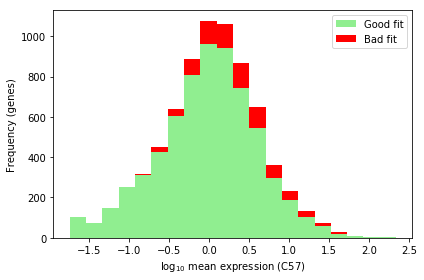

In [17]:
plt.hist([me[gof_series > 0.05], me[gof_series < 0.05]],bins=20, stacked=True, color=['lightgreen', 'red'], label=['Good fit','Bad fit'])
plt.xlabel(r'log$_{10}$ mean expression (C57)')
plt.ylabel('Frequency (genes)')
plt.legend()
plt.tight_layout()
plt.savefig('figures/ExtDataFig10c.pdf')
plt.show()

In [19]:
print(np.sum(gof_series > 0.05))

6604
